# Determine the amount of neutralizing activity directed towards the RBD elicited by infection with B.1.351

## Set up analysis
Import packages

In [1]:
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import lifelines
import sklearn
import scipy.stats

import yaml

print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 0.5.7


Use seaborn theme and change font:

In [2]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

Read in config file

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Define results directory

In [4]:
resultsdir = 'results/rbd_depletion_neuts'
os.makedirs(resultsdir, exist_ok=True)

## Read in fracinfect file and plot curves

Read in the neut data for all experiments for this paper, but only select the date(s) that correspond to the RBD depletions experiment. Note that this is only configured to handle one experiment date currently (because the amazingly talented Rachel Eguia ran all these assays on a single date). So for future projects, this might need to be adjusted. 

In [5]:
rbd_depletions_date = str(config['rbd_depletions_date'])
print(f'Getting data from {rbd_depletions_date}')

frac_infect = (pd.read_csv(config['aggregate_fract_infect_csvs'])
               .query('date==@rbd_depletions_date')
               .replace({'mock': 'mock depletion'})
              )

fits = neutcurve.CurveFits(frac_infect)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'depletion', 'wildtype':'mock depletion'})
    # get columns of interest
    [['serum', 'depletion', 'ic50', 'ic50_bound']]
    .assign(NT50=lambda x: 1/x['ic50'])
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

display(HTML(fitparams.to_html(index=False)))

Getting data from 2021-06-10


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power


serum,depletion,ic50,ic50_bound,NT50,ic50_is_bound
pre-pandemic,mock depletion,0.040000,lower,25.000000,True
K006,mock depletion,0.040000,lower,25.000000,True
K119,mock depletion,0.000197,interpolated,5081.755209,False
K119,RBD antibodies depleted,0.007951,interpolated,125.772359,False
K116,mock depletion,0.040000,lower,25.000000,True
K116,RBD antibodies depleted,0.040000,lower,25.000000,True
REGN10987 (spike-in),mock depletion,0.006938,interpolated,144.127658,False
REGN10987 (spike-in),RBD antibodies depleted,0.250000,lower,4.000000,True
K114,mock depletion,0.000879,interpolated,1138.078550,False
K114,RBD antibodies depleted,0.022327,interpolated,44.788025,False


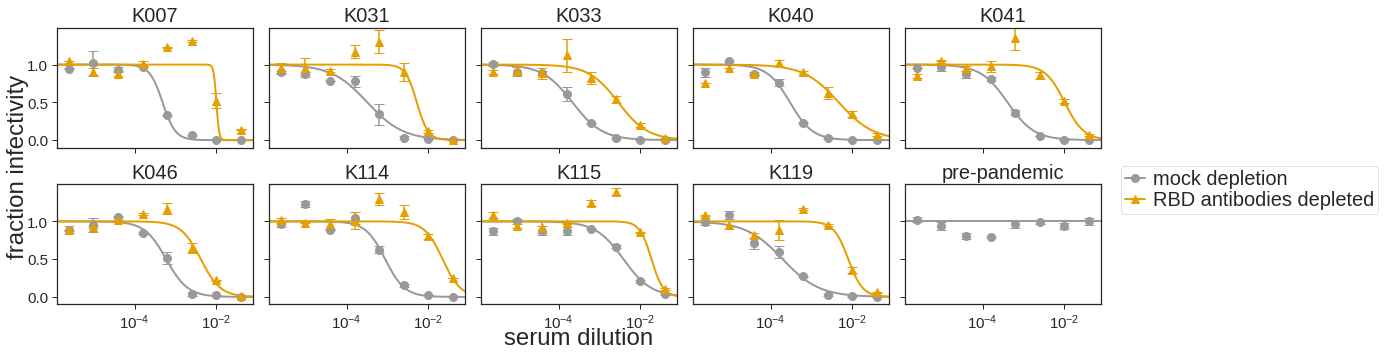

In [6]:
non_neut=["REGN10987 (spike-in)", "K006", "K116"]

fig, axes = fits.plotSera(sera=natsort.natsorted(fitparams.query('serum not in @non_neut')['serum'].unique()),
                          xlabel='serum dilution',
                          ncol=5,
                          widthscale=1,
                          heightscale=1,
                          titlesize=20, labelsize=24, ticksize=15, legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=8, linewidth=2,
                         )

plotfile = PdfPages(f'{resultsdir}/sera_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

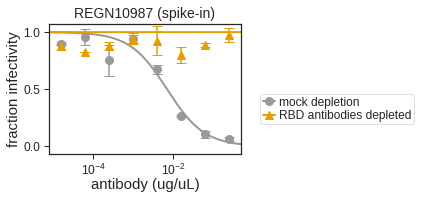

In [7]:
fig, axes = fits.plotSera(sera=natsort.natsorted(fitparams.query('serum=="REGN10987 (spike-in)"')['serum'].unique()),
                          xlabel='antibody (ug/uL)',
                          yticklocs=[0,0.5,1],
                          markersize=8, linewidth=2,
                         )

plotfile = PdfPages(f'{resultsdir}/REGN10987_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

In [8]:
# define which sera to exclude from downstream analyses
exclude_sera = ["pre-pandemic", "REGN10987 (spike-in)", "K006", "K116"]

In [9]:
foldchange = (
    fitparams
    .query('serum not in @exclude_sera')
    .pivot_table(values='ic50', index=['serum'], columns=['depletion'])
    .reset_index()
    .rename(columns={'RBD antibodies depleted': 'post-depletion_ic50', 'mock depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            percent_RBD= lambda x: ((1-1/x['fold_change'])*100).astype(int),
            NT50_pre=lambda x: 1/x['pre-depletion_ic50'],
            NT50_post=lambda x: 1/x['post-depletion_ic50'],
           )
    .merge(fitparams.query('depletion=="RBD antibodies depleted"')[['serum', 'ic50_is_bound']], on='serum')
    .assign(perc_RBD_str = lambda x: x['percent_RBD'].astype(str)
           )
    .rename(columns={'ic50_is_bound': 'post_ic50_bound'})
    .merge(fitparams)
    .assign(depletion=lambda x: pd.Categorical(x['depletion'], categories=['mock depletion', 'RBD antibodies depleted'], ordered=True))
    )

foldchange['perc_RBD_str'] = np.where(foldchange['post_ic50_bound'], '>'+foldchange['perc_RBD_str']+'%', foldchange['perc_RBD_str']+'%')
display(HTML(foldchange.head(10).to_html(index=False)))

serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,NT50_pre,NT50_post,post_ic50_bound,perc_RBD_str,depletion,ic50,ic50_bound,NT50,ic50_is_bound
K007,0.010060,0.000484,20.800716,95,2067.627899,99.401766,False,95%,mock depletion,0.000484,interpolated,2067.627899,False
K007,0.010060,0.000484,20.800716,95,2067.627899,99.401766,False,95%,RBD antibodies depleted,0.010060,interpolated,99.401766,False
K031,0.005240,0.000322,16.288136,93,3108.634600,190.852692,False,93%,mock depletion,0.000322,interpolated,3108.634600,False
K031,0.005240,0.000322,16.288136,93,3108.634600,190.852692,False,93%,RBD antibodies depleted,0.005240,interpolated,190.852692,False
K033,0.002881,0.000217,13.256727,92,4600.806832,347.054493,False,92%,mock depletion,0.000217,interpolated,4600.806832,False
K033,0.002881,0.000217,13.256727,92,4600.806832,347.054493,False,92%,RBD antibodies depleted,0.002881,interpolated,347.054493,False
K040,0.004643,0.000297,15.642334,93,3369.006960,215.377504,False,93%,mock depletion,0.000297,interpolated,3369.006960,False
K040,0.004643,0.000297,15.642334,93,3369.006960,215.377504,False,93%,RBD antibodies depleted,0.004643,interpolated,215.377504,False
K041,0.010180,0.000407,25.035766,96,2459.294005,98.231227,False,96%,mock depletion,0.000407,interpolated,2459.294005,False
K041,0.010180,0.000407,25.035766,96,2459.294005,98.231227,False,96%,RBD antibodies depleted,0.010180,interpolated,98.231227,False


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3.5 x 2.25 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/rbd_depletion_neuts/NT50_trackplot.pdf


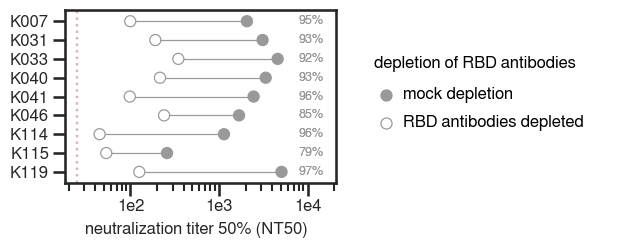

In [10]:
p = (ggplot(foldchange
            .assign(
                    serum=lambda x: pd.Categorical(x['serum'], natsort.natsorted(x['serum'].unique())[::-1], ordered=True)
                   )
            , 
            aes(x='NT50',
                y='serum',
                fill='depletion',
                group='serum',
                label='perc_RBD_str'
               )) +
     scale_x_log10(name='neutralization titer 50% (NT50)', 
                   limits=[25,foldchange['NT50'].max()*3]) +
     geom_vline(xintercept=25, 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
     geom_line(alpha=1, color=CBPALETTE[0]) +
     geom_point(size=4, color=CBPALETTE[0]) +
     geom_text(aes(x=foldchange['NT50'].max()*3, y='serum'), #
               color=CBPALETTE[0],
               ha='right',
               size=9,
              ) +
     theme(figure_size=(3.5,0.25*foldchange['serum'].nunique()),
           axis_text=element_text(size=12),
           legend_text=element_text(size=12),
           legend_title=element_text(size=12),
           axis_title_x=element_text(size=12),
          ) +
     ylab('') +
     scale_fill_manual(values=['#999999', '#FFFFFF', ], 
                       name='depletion of RBD antibodies')
    )

_ = p.draw()

p.save(f'{resultsdir}/NT50_trackplot.pdf')

In [11]:
# Assign days post symptom onset for samples:
collection_day={
'K007':40,
'K031':34,
'K033':35,
'K040':37,
'K041':30,
'K046':33,
'K114':31,
'K115':27,
'K116':34,
'K119':29,
}

foldchange=foldchange.assign(day=lambda x: x['serum'].map(collection_day))

In [12]:
conv_plasma = (pd.read_csv('data/haarvi_rbd_depletion_foldchange_ic50.csv')
               [['serum', 'depletion', 'NT50', 'fold_change',  'percent_RBD', 'Days Post-Symptom Onset', 'post_ic50_bound']]
               .rename(columns={'Days Post-Symptom Onset':'day'})
               .assign(sample_type='Wuhan-1-like')
               .query('serum!="participant A (day 45)"') # dropping subject A (day 45) because we will only use the first time point
              )

compare_df = (pd.concat([conv_plasma, 
                        (foldchange[['serum', 'depletion', 'NT50', 'fold_change', 'percent_RBD', 'day', 'post_ic50_bound']]
                         .assign(sample_type='B.1.351'))
                       ],
                       ignore_index=True
                      )
              .replace({'pre-depletion': 'pre', 'post-depletion':'post', 'mock depletion': 'pre', 'RBD antibodies depleted': 'post'})
              .assign(depletion=lambda x: pd.Categorical(x['depletion'], categories=['pre', 'post'], ordered=True), 
                      sample_type=lambda x: pd.Categorical(x['sample_type'], categories=['Wuhan-1-like', 'B.1.351'], ordered=True),
                      early_late=lambda x: x['day'].apply(lambda x: 'day 30-60' if x<=61 else 'day 100-150'),
                     )
              .assign(early_late=lambda x: pd.Categorical(x['early_late'], categories=['day 30-60', 'day 100-150'], ordered=True),)
             )
               
display(HTML(compare_df.head().to_html(index=False))) 

csvfile=f'{resultsdir}/RBD_depletion_NT50_b1351_haarvi.csv'
print(f'Writing to {csvfile}')
compare_df.to_csv(csvfile, index=False)

serum,depletion,NT50,fold_change,percent_RBD,day,post_ic50_bound,sample_type,early_late
participant A (day 120),pre,861.163942,43.058197,97,120,True,Wuhan-1-like,day 100-150
participant A (day 120),post,20.000000,43.058197,97,120,True,Wuhan-1-like,day 100-150
participant A (day 21),pre,6881.224570,8.142050,87,21,False,Wuhan-1-like,day 30-60
participant A (day 21),post,845.146407,8.142050,87,21,False,Wuhan-1-like,day 30-60
participant B (day 113),pre,284.860372,14.243019,92,113,True,Wuhan-1-like,day 100-150


Writing to results/rbd_depletion_neuts/RBD_depletion_NT50_b1351_haarvi.csv


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 3 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_Wuhan1_B1351_RBDtargeting.pdf


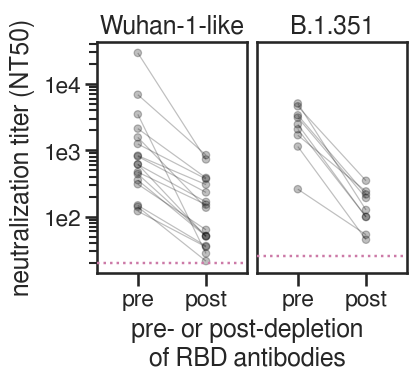

In [13]:
LOD = (pd.DataFrame(data={'sample_type': ['Wuhan-1-like', 'B.1.351'], 'NT50': [20, 25]})
      .assign(sample_type=lambda x: pd.Categorical(x['sample_type'], categories=['Wuhan-1-like', 'B.1.351'], ordered=True))
      )

NT50_lines = (ggplot(compare_df.query("early_late=='day 30-60'"), aes(x='depletion', y='NT50', group='serum')) + 
              geom_point(size=2.5, alpha=0.25) +
              geom_line(alpha=0.25) +
              facet_wrap('~sample_type') +
              theme(axis_title_y=element_text(margin={'r': 6}),
                    strip_background=element_blank(),
                    figure_size=(4, 3),) +
              scale_y_log10(name='neutralization titer (NT50)') +
              xlab('pre- or post-depletion\nof RBD antibodies') +
              geom_hline(data=LOD,
                             mapping=aes(yintercept='NT50'),
                             color=CBPALETTE[7],
                             alpha=1,
                             size=1,
                             linetype='dotted',
                            )
                 )

_ = NT50_lines.draw()
NT50_lines.save(f'{resultsdir}/compare_Wuhan1_B1351_RBDtargeting.pdf')

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 3 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: results/rbd_depletion_neuts/compare_percentRBD.pdf


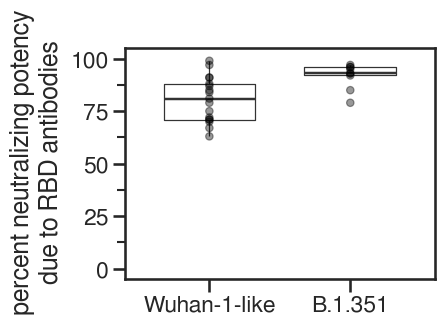

In [14]:
p = (ggplot((compare_df.query("early_late=='day 30-60'").drop(columns=['depletion', 'NT50']).drop_duplicates())
           ) +
     aes('sample_type', 'percent_RBD') +
     geom_boxplot(width=0.65,
                  position=position_dodge(width=0.7),
                  outlier_shape='') +
     geom_jitter(position=position_dodge(width=0.7),
                 alpha=0.4, size=2.5) +
     theme(figure_size=(4, 3),
           strip_background=element_blank()
           ) +
     scale_y_continuous(limits=[0, 100]) +
     ylab('percent neutralizing potency\ndue to RBD antibodies') +
     xlab ('')
     )

_ = p.draw()
p.save(f'{resultsdir}/compare_percentRBD.pdf')

In [15]:
stat_test_df = (compare_df
                .query("early_late=='day 30-60'")
                [['serum', 'sample_type', 'fold_change', 'percent_RBD', 'post_ic50_bound']]
                .drop_duplicates()
               )
# display(HTML(stat_test_df.to_html()))

print(f"Comparing Wuhan-1-like to B.1.351")
percent_1 = stat_test_df.query('sample_type == "Wuhan-1-like"')['percent_RBD']
percent_2 = stat_test_df.query('sample_type == "B.1.351"')['percent_RBD']
u, p = scipy.stats.mannwhitneyu(percent_1, percent_2)
print(f"  Mann-Whitney test:      P = {p:.2g}")
res = lifelines.statistics.logrank_test(percent_1, percent_2)
print(f"  Log-rank test:          P = {res.p_value:.2g}")
censored_1 = (~stat_test_df.query('sample_type == "Wuhan-1-like"')['post_ic50_bound']).astype(int)
censored_2 = (~stat_test_df.query('sample_type == "B.1.351"')['post_ic50_bound']).astype(int)
res = lifelines.statistics.logrank_test(percent_1, percent_2, censored_1, censored_2)
print(f"  Log-rank test censored: P = {res.p_value:.2g}")
# actually, Cox regression is recommended over log-rank test, see here:
# https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html
cox_df = pd.concat([
        pd.DataFrame({'E': censored_1, 'T': percent_1, 'groupA': 1}),
        pd.DataFrame({'E': censored_2, 'T': percent_2, 'groupA': 0})
        ])
cph = lifelines.CoxPHFitter().fit(cox_df, 'T', 'E')
print(f"  Cox proportional-hazards censored: P = {cph.summary.at['groupA', 'p']:.2g}")

Comparing Wuhan-1-like to B.1.351
  Mann-Whitney test:      P = 0.0061
  Log-rank test:          P = 0.087
  Log-rank test censored: P = 0.087
  Cox proportional-hazards censored: P = 0.12
